## Machine Learning Engineer Nanodegree
## Capstone Project
**Markus Buchholz**  
05/08/2017


In [1]:
import gym
import tensorflow as tf
import numpy as np
from collections import deque

## HYPERPARAMETERS

In [2]:
train_episodes = 500          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate

# Network parameters
hidden_size = 128               # number of hidden layer
learning_rate = 0.0001         # learning rate

# Memory parameters
memory_size = 10000            # memory size
batch_size = 32                # batch size
pretrain_length = 500          # random games

In [3]:
# Initialise Cart-Pole environment
env = gym.make('CartPole-v0')

[2017-08-06 14:03:22,265] Making new env: CartPole-v0


In [4]:
env.reset()
rewards = []
for _ in range(100):

    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

In [5]:
class Neural_Network:
    def __init__(self, learning_rate=0.0001, state_size=4, action_size=2, hidden_size=128, name='Neural_Network'):
        
        # Input
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode and actions
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Targets
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # Hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size)
            

            # Output
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size, activation_fn=None)
            
            ### Training of Neural_Network (Q value)
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            #Optimilzer
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            #self.opt = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)
           

## Memory inicialisation and management



In [6]:
tf.reset_default_graph()
mainQN = Neural_Network(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

In [7]:
#random_states = []
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.random_states = []
        self.init_memory()
    
    def add(self, experience):
        self.buffer.append(experience)
        #print("test1")
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
    
    
    def init_memory (self):
   
        # Initialize the simulation
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())

        #memory = Memory(max_size=memory_size)

        # Make a bunch of random actions and store the experiences
        for ii in range(pretrain_length):
            # Uncomment the line below to watch the simulation
            # env.render()

            # Make a random action
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            self.random_states.append(next_state)

            if done:
                # The simulation fails so no next state
                next_state = np.zeros(state.shape)
                # Add experience to memory
                self.add((state, action, reward, next_state))

                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                #random_states.append(state)
                #print (state)
            else:
                # Add experience to memory
                self.add((state, action, reward, next_state))
                state = next_state
             
memory = Memory(max_size=memory_size)
#print (memory.random_states)    

## Exploratory Visualization



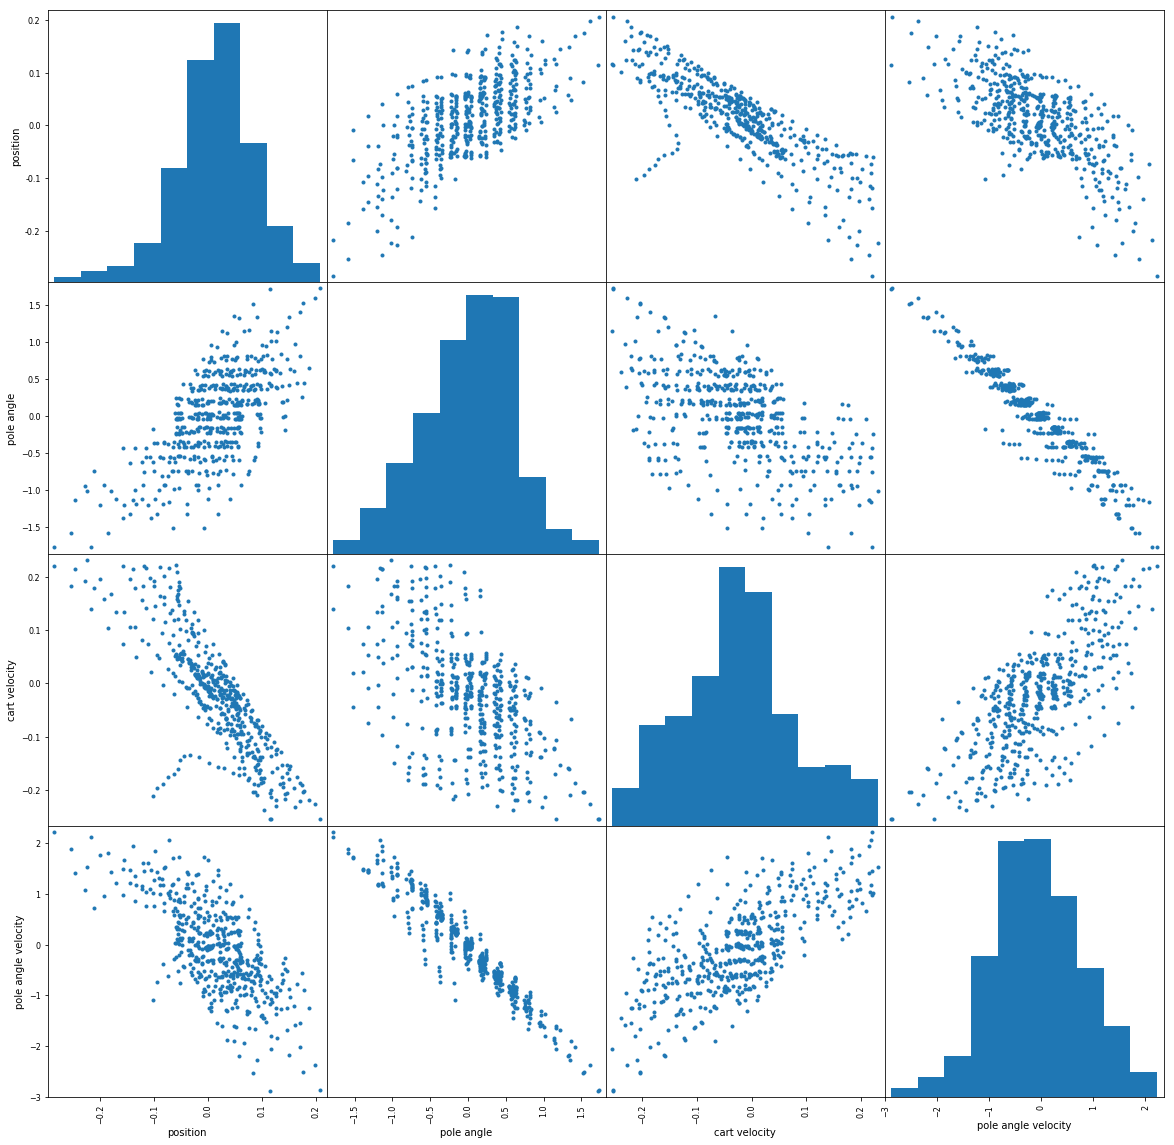

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(memory.random_states, columns=['position', 'pole angle', 'cart velocity', 'pole angle velocity'])
axes = pd.tools.plotting.scatter_matrix(df, alpha=1, figsize=(20, 20))

plt.show()

## Descriptive Statistics

### Summary statistics

In [9]:
#df = pd.DataFrame(memory.random_states, columns=['position', 'pole angle', 'cart velocity', 'pole angle velocity'])
#axes = pd.tools.plotting.scatter_matrix(df, alpha=1, figsize=(20, 20))
df = pd.DataFrame(df, columns = ['position', 'pole angle', 'cart velocity', 'pole angle velocity'])
#df['position', 'pole angle', 'cart velocity', 'pole angle velocity'].describe()
df[['position', 'pole angle', 'cart velocity', 'pole angle velocity']].describe()



,position,pole angle,cart velocity,pole angle velocity
count,500.000000,500.000000,500.000000,500.000000
mean,0.013596,0.001835,-0.023820,-0.090047
std,0.075276,0.604402,0.103373,0.883297
min,-0.284991,-1.781474,-0.254713,-2.885569
25%,-0.028187,-0.383221,-0.090624,-0.650260
50%,0.020580,0.023359,-0.021766,-0.104200
75%,0.058775,0.407933,0.033127,0.517214
max,0.206538,1.730548,0.230871,2.221902


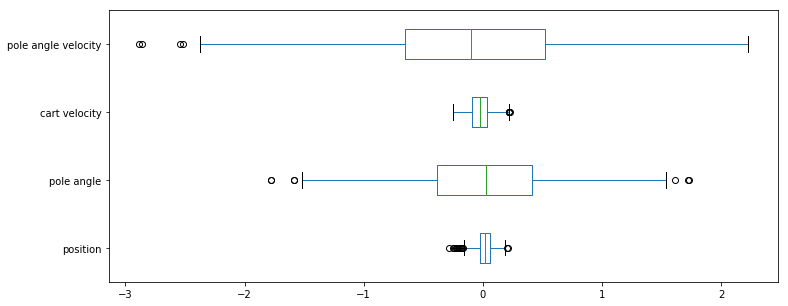

In [10]:
df.plot.box(vert=False,figsize=(12, 5))
#plt.figure(figsize=(10,6))

## Variance

In [11]:
a = ['position', 'pole angle', 'cart velocity', 'pole angle velocity']
i = [j for j in range (len(a))]
b_var = df[a].var()
for i in range(len (a)):
    print("variance for ", a[i], "=", b_var[i])

variance for  position = 0.00566645586358
variance for  pole angle = 0.365301693713
variance for  cart velocity = 0.0106859952702
variance for  pole angle velocity = 0.7802134536


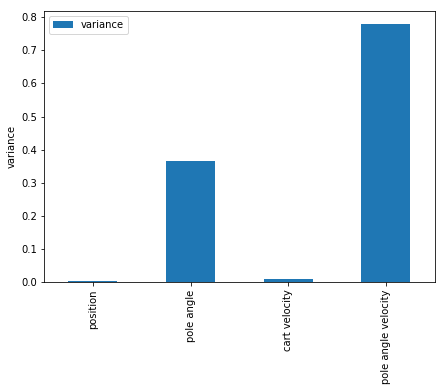

In [12]:
%matplotlib inline
plt.figure(figsize=(7,5))

b_var.plot.bar(label='variance')
plt.ylabel('variance')
plt.legend()

##  Standard deviation

In [13]:
#df[['position', 'pole angle', 'cart velocity', 'pole angle velocity']].std()

b_std = df[a].std()
for i in range(len (a)):
    print("standard deviation for ", a[i], "=", b_std[i])



standard deviation for  position = 0.0752758650802
standard deviation for  pole angle = 0.6044019306
standard deviation for  cart velocity = 0.103373087746
standard deviation for  pole angle velocity = 0.883296922671


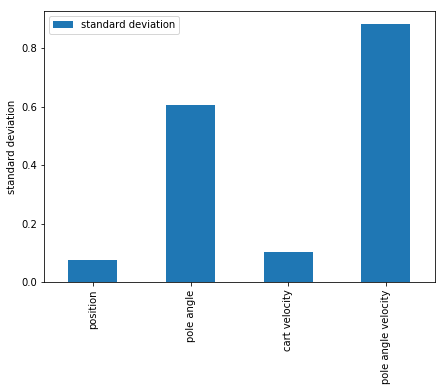

In [14]:
plt.figure(figsize=(7,5))

b_std.plot.bar(label='standard deviation')
plt.ylabel('standard deviation')
plt.legend()

## Correlation Matrix Of Values

In [15]:
df.corr()

,position,pole angle,cart velocity,pole angle velocity
position,1.000000,0.670180,-0.816618,-0.702026
pole angle,0.670180,1.000000,-0.545937,-0.957117
cart velocity,-0.816618,-0.545937,1.000000,0.719251
pole angle velocity,-0.702026,-0.957117,0.719251,1.000000


## Covariance Matrix Of Values

In [16]:
df.cov()

,position,pole angle,cart velocity,pole angle velocity
position,0.005666,0.030491,-0.006355,-0.046678
pole angle,0.030491,0.365302,-0.034110,-0.510973
cart velocity,-0.006355,-0.034110,0.010686,0.065674
pole angle velocity,-0.046678,-0.510973,0.065674,0.780213


## Training phase


In [17]:
import math
#rewards_list = []
saver = tf.train.Saver()
def training():
    #mem = Memory()
    state, reward, done, _ = env.step(env.action_space.sample())

    rewards_list = []
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        step = 0
        for ep in range(1, train_episodes):
            total_reward = 0
            t = 0
            while t < max_steps:
                step += 1

                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
             
                if explore_p > np.random.rand():
                    # Make a random action
                    action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)

                total_reward += reward

                if done:
                    # the episode ends so no next state
                    next_state = np.zeros(state.shape)
                    t = max_steps

                    print('Episode: {}'.format(ep),
                          'Total reward: {}'.format(total_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Explore P: {:.4f}'.format(explore_p))
                    rewards_list.append((ep, total_reward))

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))

                    # Start new episode
                    env.reset()
                    # Take one random step to get the pole and cart moving
                    state, reward, done, _ = env.step(env.action_space.sample())

                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = next_state
                    t += 1

                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])
               #print("length", len(next_states))
                #print("next states", next_states)

                # Train network
                target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

                # Set target_Qs to 0 for states where episode ends
                episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
                target_Qs[episode_ends] = (0, 0)

                targets = rewards + gamma * np.max(target_Qs, axis=1)

                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: targets,
                                               mainQN.actions_: actions})
               # print(rewards_list)
        saver.save(sess, "../cartpole_model.ckpt")   
    return rewards_list
        


In [18]:
rewards_list = training()
#print(rewards_list)

Episode: 1 Total reward: 45.0 Training loss: 1.0682 Explore P: 0.9956
Episode: 2 Total reward: 9.0 Training loss: 1.0882 Explore P: 0.9947
Episode: 3 Total reward: 20.0 Training loss: 1.1599 Explore P: 0.9927
Episode: 4 Total reward: 17.0 Training loss: 1.3982 Explore P: 0.9910
Episode: 5 Total reward: 24.0 Training loss: 1.3970 Explore P: 0.9887
Episode: 6 Total reward: 11.0 Training loss: 1.2926 Explore P: 0.9876
Episode: 7 Total reward: 43.0 Training loss: 2.1117 Explore P: 0.9834
Episode: 8 Total reward: 18.0 Training loss: 3.7794 Explore P: 0.9817
Episode: 9 Total reward: 12.0 Training loss: 4.0740 Explore P: 0.9805
Episode: 10 Total reward: 9.0 Training loss: 7.6116 Explore P: 0.9796
Episode: 11 Total reward: 11.0 Training loss: 3.7682 Explore P: 0.9786
Episode: 12 Total reward: 12.0 Training loss: 9.4739 Explore P: 0.9774
Episode: 13 Total reward: 14.0 Training loss: 11.7412 Explore P: 0.9760
Episode: 14 Total reward: 37.0 Training loss: 5.8231 Explore P: 0.9725
Episode: 15 Tota

Episode: 117 Total reward: 52.0 Training loss: 23.7542 Explore P: 0.7701
Episode: 118 Total reward: 52.0 Training loss: 71.9876 Explore P: 0.7661
Episode: 119 Total reward: 37.0 Training loss: 55.0841 Explore P: 0.7633
Episode: 120 Total reward: 19.0 Training loss: 20.5229 Explore P: 0.7619
Episode: 121 Total reward: 17.0 Training loss: 71.4335 Explore P: 0.7606
Episode: 122 Total reward: 25.0 Training loss: 241.9226 Explore P: 0.7587
Episode: 123 Total reward: 27.0 Training loss: 45.1741 Explore P: 0.7567
Episode: 124 Total reward: 29.0 Training loss: 25.7698 Explore P: 0.7546
Episode: 125 Total reward: 27.0 Training loss: 71.2928 Explore P: 0.7526
Episode: 126 Total reward: 17.0 Training loss: 101.2473 Explore P: 0.7513
Episode: 127 Total reward: 10.0 Training loss: 81.7005 Explore P: 0.7506
Episode: 128 Total reward: 46.0 Training loss: 29.3370 Explore P: 0.7472
Episode: 129 Total reward: 19.0 Training loss: 40.0502 Explore P: 0.7458
Episode: 130 Total reward: 15.0 Training loss: 34

Episode: 229 Total reward: 199.0 Training loss: 1157.0604 Explore P: 0.3987
Episode: 230 Total reward: 134.0 Training loss: 1571.7827 Explore P: 0.3935
Episode: 231 Total reward: 141.0 Training loss: 379.3926 Explore P: 0.3881
Episode: 232 Total reward: 123.0 Training loss: 46.0164 Explore P: 0.3835
Episode: 233 Total reward: 199.0 Training loss: 2235.3489 Explore P: 0.3761
Episode: 234 Total reward: 13.0 Training loss: 661.9439 Explore P: 0.3757
Episode: 235 Total reward: 157.0 Training loss: 488.6701 Explore P: 0.3700
Episode: 236 Total reward: 199.0 Training loss: 65.2031 Explore P: 0.3629
Episode: 237 Total reward: 142.0 Training loss: 67.6075 Explore P: 0.3579
Episode: 238 Total reward: 103.0 Training loss: 128.9852 Explore P: 0.3543
Episode: 239 Total reward: 111.0 Training loss: 140.4599 Explore P: 0.3505
Episode: 240 Total reward: 199.0 Training loss: 1785.1946 Explore P: 0.3438
Episode: 241 Total reward: 156.0 Training loss: 36.9211 Explore P: 0.3387
Episode: 242 Total reward:

Episode: 341 Total reward: 199.0 Training loss: 0.6607 Explore P: 0.0609
Episode: 342 Total reward: 199.0 Training loss: 0.5257 Explore P: 0.0599
Episode: 343 Total reward: 199.0 Training loss: 0.3140 Explore P: 0.0589
Episode: 344 Total reward: 199.0 Training loss: 1.3674 Explore P: 0.0579
Episode: 345 Total reward: 199.0 Training loss: 0.1894 Explore P: 0.0570
Episode: 346 Total reward: 199.0 Training loss: 0.4045 Explore P: 0.0560
Episode: 347 Total reward: 199.0 Training loss: 0.3830 Explore P: 0.0551
Episode: 348 Total reward: 199.0 Training loss: 0.3321 Explore P: 0.0543
Episode: 349 Total reward: 199.0 Training loss: 0.1704 Explore P: 0.0534
Episode: 350 Total reward: 199.0 Training loss: 154.9080 Explore P: 0.0525
Episode: 351 Total reward: 199.0 Training loss: 69.5927 Explore P: 0.0517
Episode: 352 Total reward: 199.0 Training loss: 0.7552 Explore P: 0.0509
Episode: 353 Total reward: 199.0 Training loss: 0.3854 Explore P: 0.0501
Episode: 354 Total reward: 199.0 Training loss: 

Episode: 453 Total reward: 199.0 Training loss: 0.6034 Explore P: 0.0155
Episode: 454 Total reward: 199.0 Training loss: 0.3394 Explore P: 0.0154
Episode: 455 Total reward: 199.0 Training loss: 0.6879 Explore P: 0.0153
Episode: 456 Total reward: 199.0 Training loss: 0.6526 Explore P: 0.0152
Episode: 457 Total reward: 199.0 Training loss: 0.5862 Explore P: 0.0151
Episode: 458 Total reward: 199.0 Training loss: 0.4002 Explore P: 0.0150
Episode: 459 Total reward: 199.0 Training loss: 0.4843 Explore P: 0.0149
Episode: 460 Total reward: 199.0 Training loss: 0.2661 Explore P: 0.0148
Episode: 461 Total reward: 199.0 Training loss: 0.4366 Explore P: 0.0147
Episode: 462 Total reward: 199.0 Training loss: 0.3387 Explore P: 0.0146
Episode: 463 Total reward: 199.0 Training loss: 1.0943 Explore P: 0.0145
Episode: 464 Total reward: 199.0 Training loss: 0.3087 Explore P: 0.0144
Episode: 465 Total reward: 199.0 Training loss: 0.4530 Explore P: 0.0143
Episode: 466 Total reward: 199.0 Training loss: 0.3

## Visualizing training

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
count_limit = [0]*100
mean_buffer = []

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

def average_reward (value):
    for i in range(len(value)):
        count_limit.pop(0)
        count_limit.append(value[i])
        #mean_buffer.append(np.mean(count_limit))
        if np.mean(count_limit)>=195:
            mean_buffer.append(i)
            
    print ("game is solved after episode: ", mean_buffer[0])
    
    

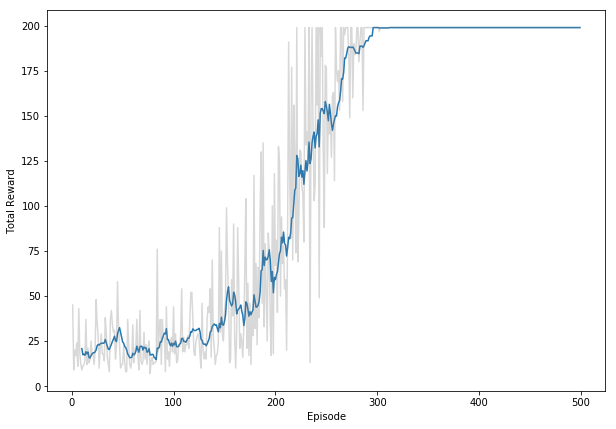

In [20]:
eps, rews = np.array(rewards_list).T
plt.figure(figsize=(10,7))
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
#plt.figure(figsize=(20,30))
plt.xlabel('Episode')
plt.ylabel('Total Reward')
#plt.show()



In [21]:
average_reward (rews)

game is solved after episode:  357


## Testing phase


In [22]:
test_episodes = 21
test_max_steps = 500
scores = []
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('../'))
    
    for ep in range(1, test_episodes):
        t = 0
        score = 0
        while t < test_max_steps:
           # env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            score = score + reward
            if done:
                
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1
        scores.append(score)        


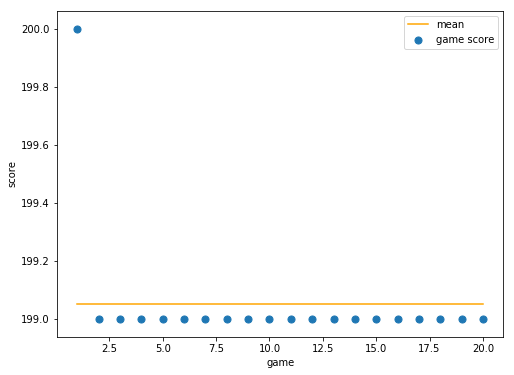

In [23]:
game = [game+1 for game in range (len(scores))]
plt.figure(figsize=(8,6))
mean_score = [np.mean(scores) for mean_sc in range (len(scores))]

plt.scatter(game,scores,s = 50, label='game score')
plt.plot(game, mean_score, color = 'orange', label='mean')

plt.xlabel('game')
plt.ylabel('score')
plt.legend()
plt.show()


In [24]:
print(np.mean(scores))

199.05


In [25]:
env.close()